<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Time Series Analysis</h1>
        <h2>Correlations</h2>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn.linear_model import LinearRegression

import scipy
from scipy import stats

import watermark

%matplotlib inline
%load_ext watermark

List out the versions of all loaded libraries

In [2]:
%watermark -n -v -m -g -iv

sklearn    0.20.3
numpy      1.16.2
watermark  1.8.1
scipy      1.2.1
pandas     0.24.2
matplotlib 3.1.0
Sun Jan 12 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 56f7e567429e9f64f7fed7dddf9d3ff26329a000


Set the default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

# Pearson Correlation

Most correlation measures for time series are based on the Pearson correlation coefficient so we start by defining it

In [4]:
def pearson(x, y):
    meanx = x.mean()
    meany = y.mean()
    stdx = x.std()
    stdy = y.std()
    
    return np.mean((x - meanx) * (y - meany)) / (stdx * stdy)

Let's generate some random data

In [5]:
x = np.random.random(1000)
y = np.random.random(1000)

Perfect correlation only occurs with itself

In [6]:
pearson(x, x)

1.0

In [7]:
pearson(y, y)

1.0

Two sets of random values are uncorrelated (by definition)

Text(0, 0.5, 'y')

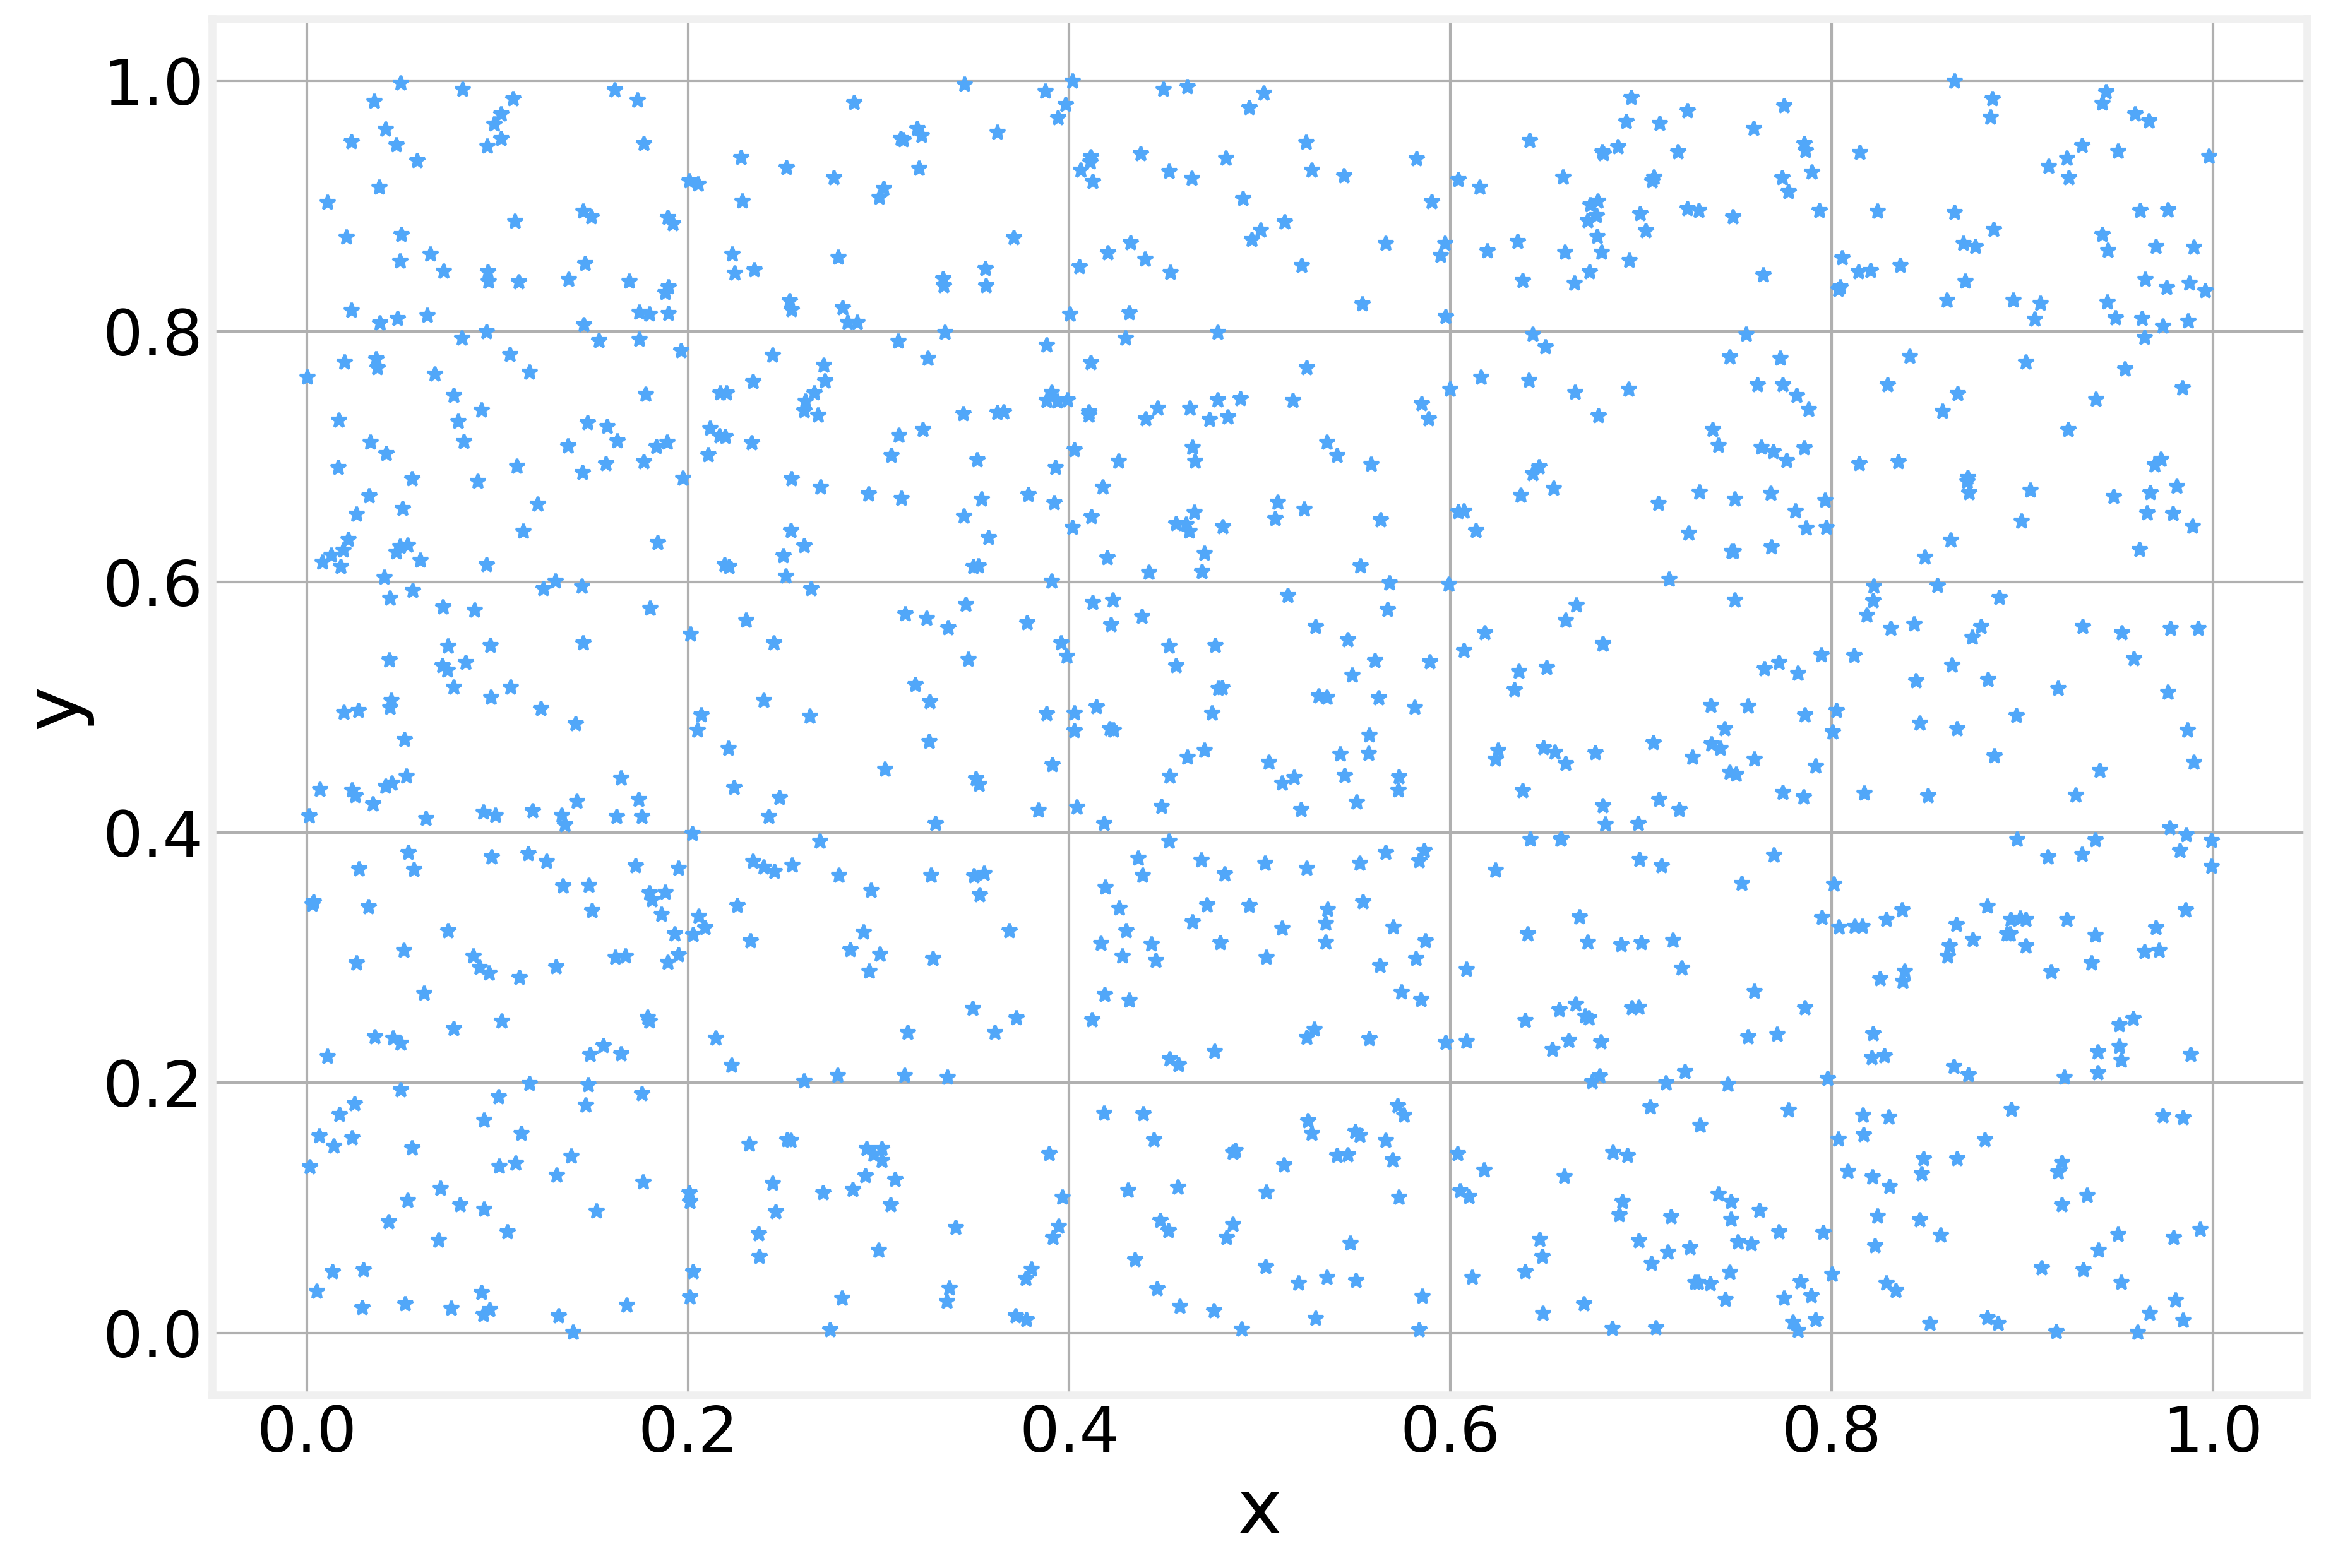

In [8]:
fig, axs = plt.subplots(1, 1)
axs.plot(x, y, '*')
axs.set_xlabel('x')
axs.set_ylabel('y')

So the Pearson correlation coefficient is very close to zero

In [9]:
pearson(x, y)

-0.036644971667563926

However, if we add a trend to the two sets of values, we quickly see a strong correlation

In [10]:
trend = np.linspace(1, 5, 1000)
pearson(x+trend, y+trend)

0.9383277728719415

This is one of the reasons why we *must* detrend timeseries before we can analyze them

# Auto-correlation

As we saw, the correlation of a series with itself is exactly 1.

In [11]:
def acf(x, lag=40):
    return np.array([1] + [pearson(x[:-i], x[i:]) for i in range(1, lag)])

But as we increase the lag the correlation decreases until it finally it simply fluctuates around zero

Text(0, 0.5, 'ACF')

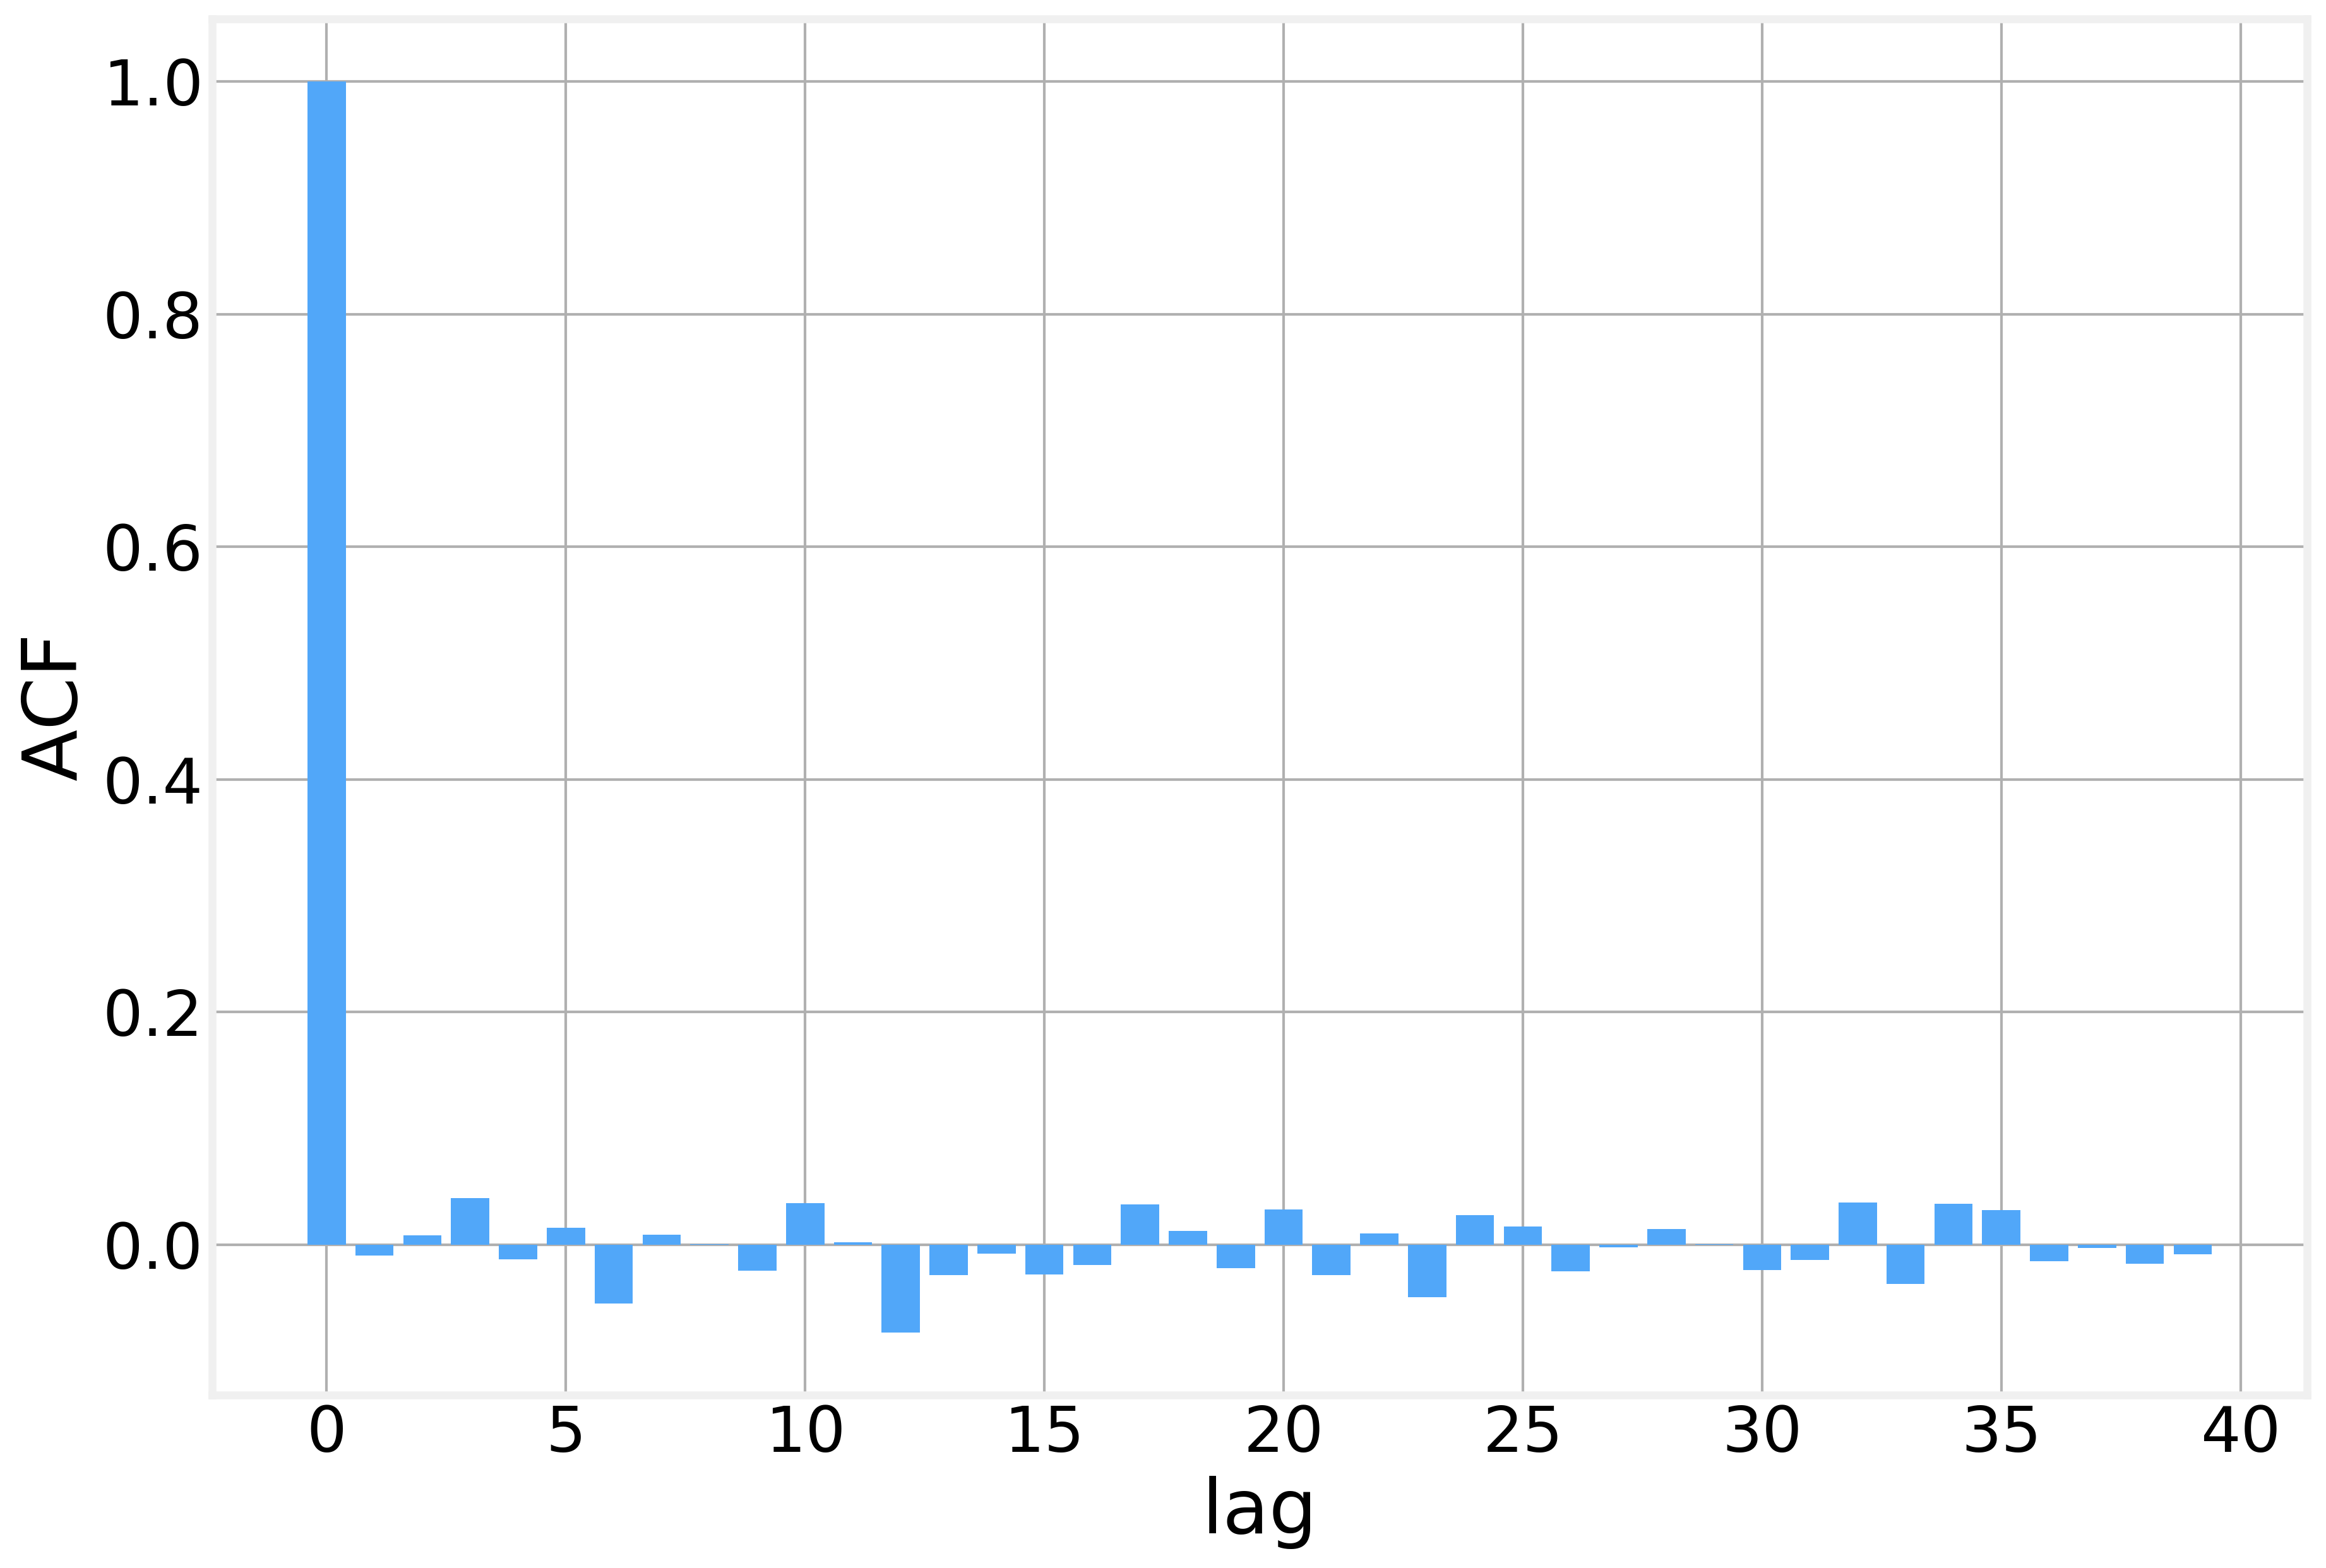

In [12]:
plt.bar(range(40), acf(x, 40))
plt.xlabel('lag')
plt.ylabel('ACF')

 How can we know when the fluctuations are significant? Fortunately there is a simple formula that gives us a confidence interval for the auto-correlation function for any specified significance level $\alpha$

In [13]:
def acf_ci(acfv, n, alpha=0.05):
    se = [1 / np.sqrt(n)]
    se.extend(np.sqrt((1+2*np.cumsum(np.power(acfv[1:-1], 2)))/n))
    se = np.array(se)
    
    se *= stats.norm.ppf(1-alpha/2.)
    return se

So that we can write a quick function to plot the auto-correlation function along with the confidence interval. Any auto-correlation value that falls inside the CI can safely be ignored

In [14]:
def plot_acf(x, lag=40, alpha=0.05):
    acf_val = acf(x, lag)
    
    plt.vlines(range(lag), 0, acf_val)
    plt.scatter(np.arange(lag), acf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('ACF')
    
    # Determine confidence interval
    ci = acf_ci(acf_val, len(x), alpha)
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

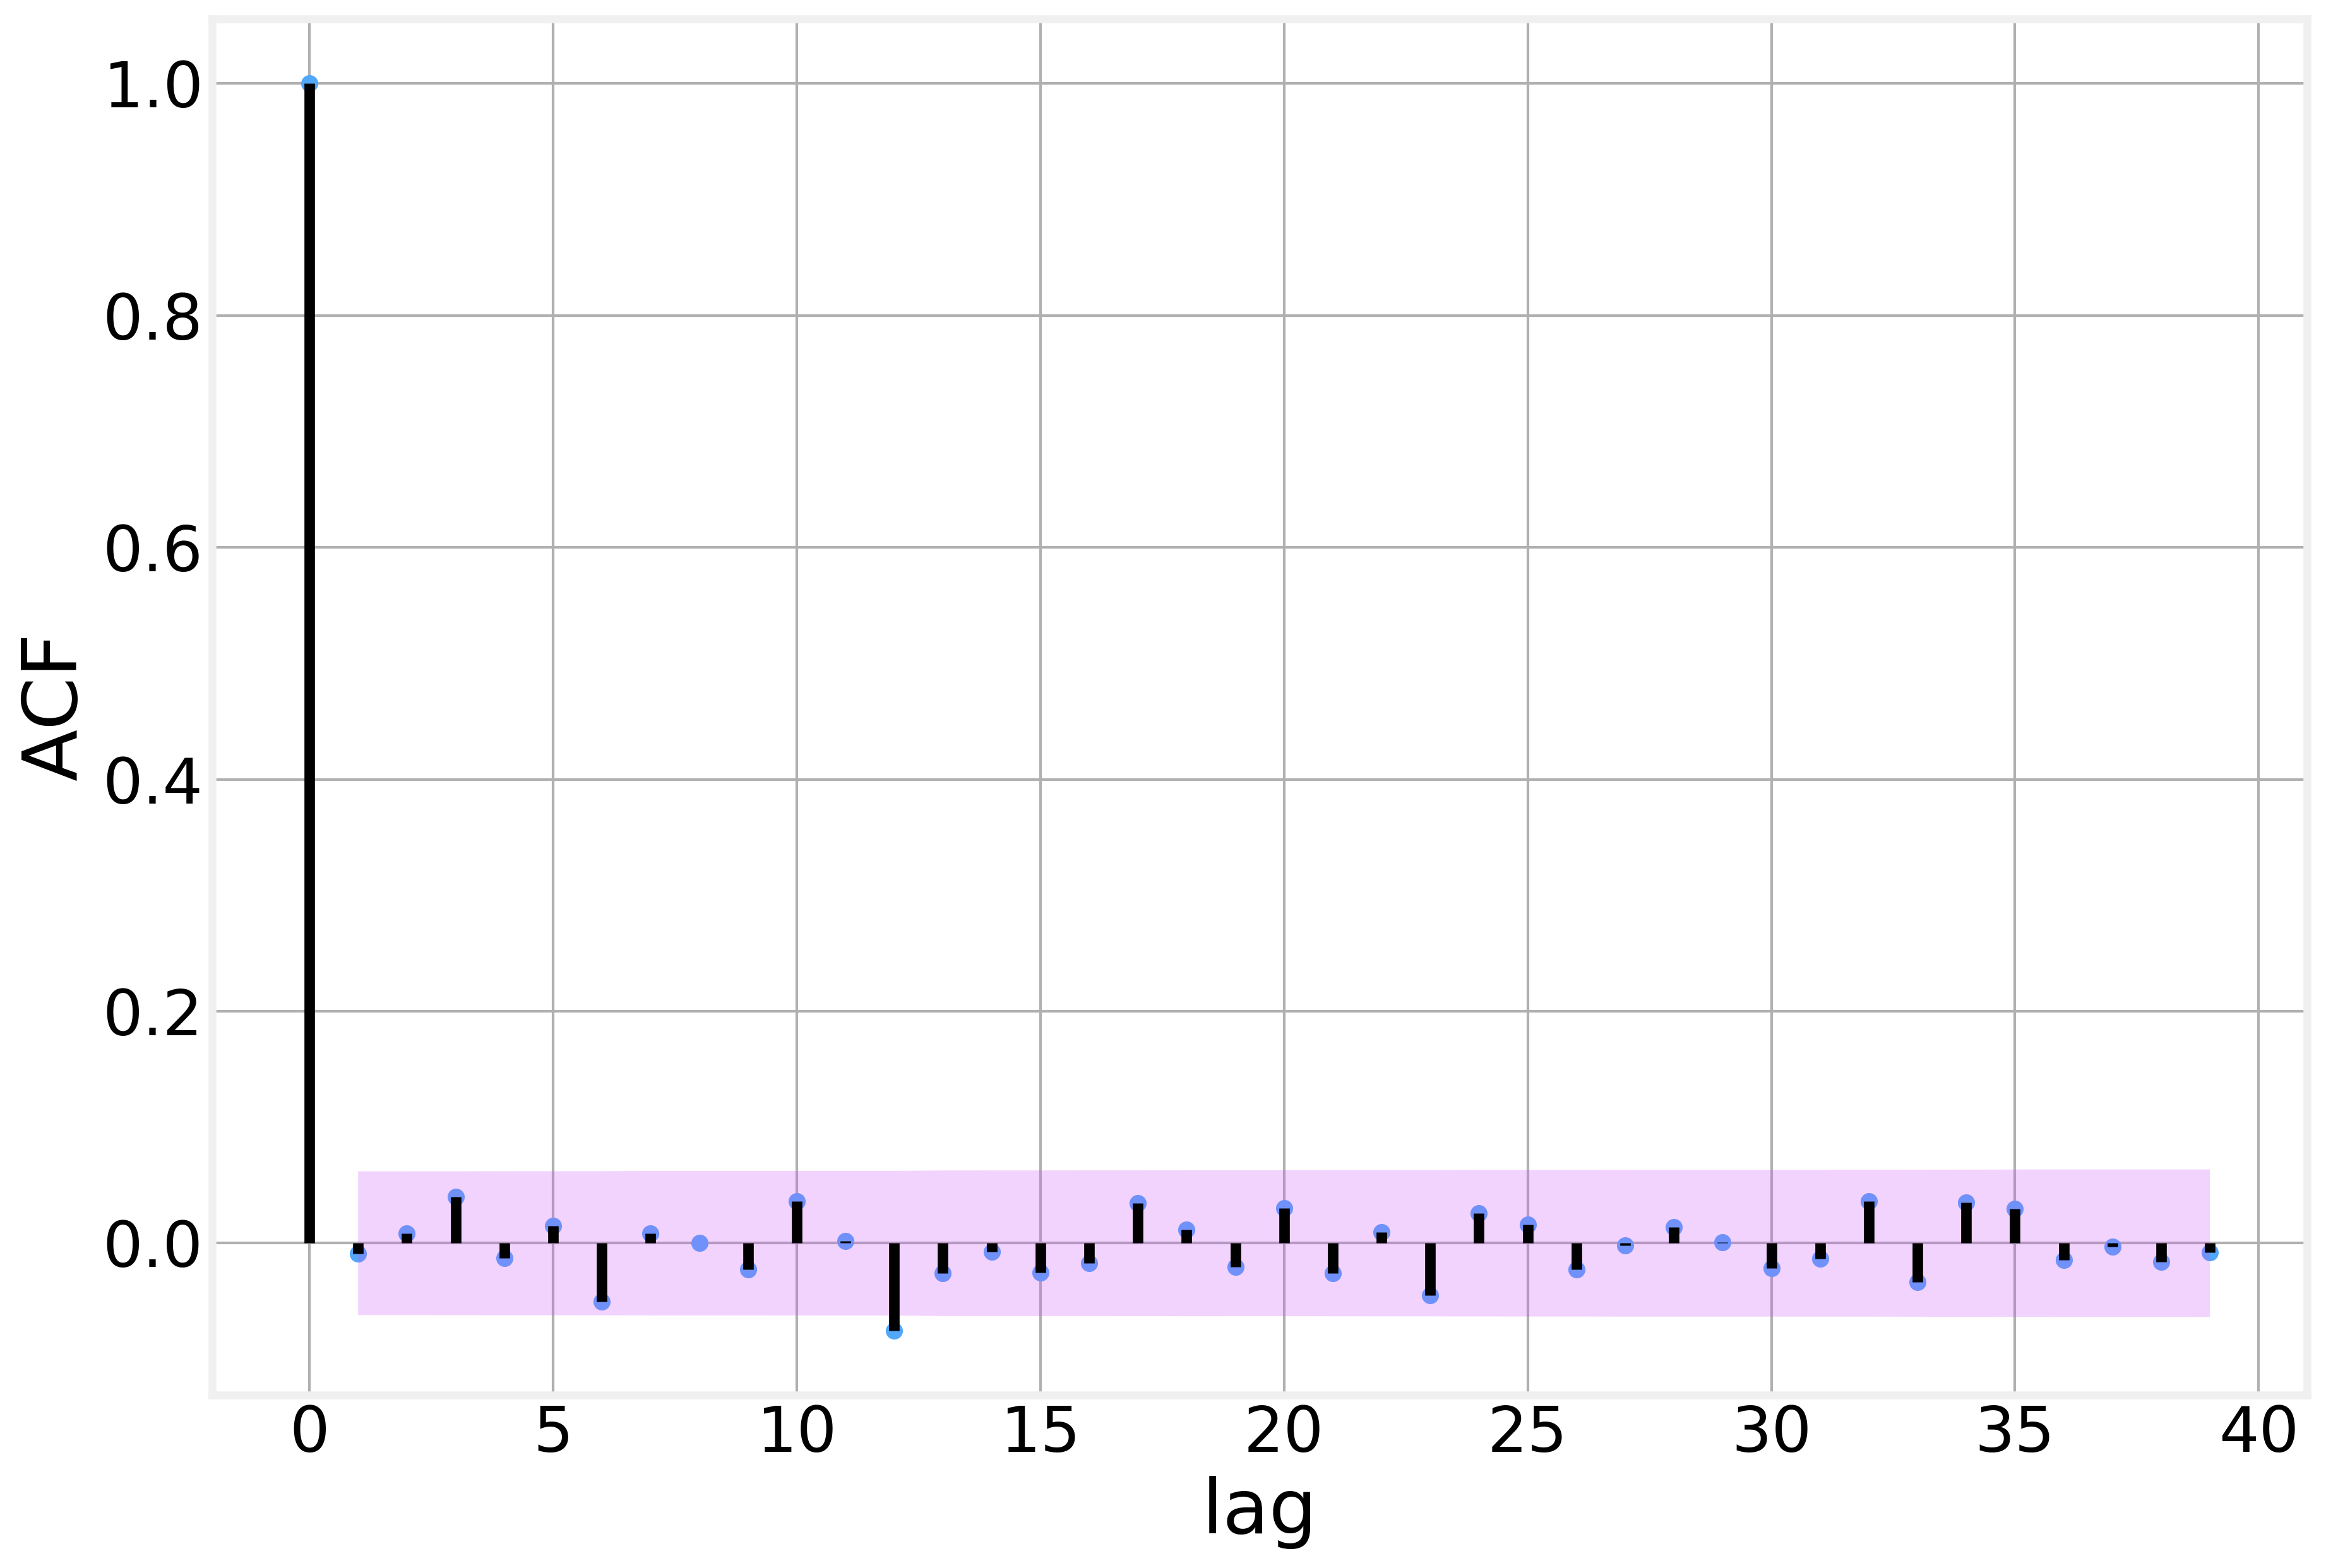

In [15]:
plot_acf(x)

Let's take a look at a real time series

In [16]:
GDP = pd.read_csv('data/GDP.csv', parse_dates=['DATE'])
GDP.set_index('DATE', inplace=True)

Text(0, 0.5, 'GDP ($\\$B$)')

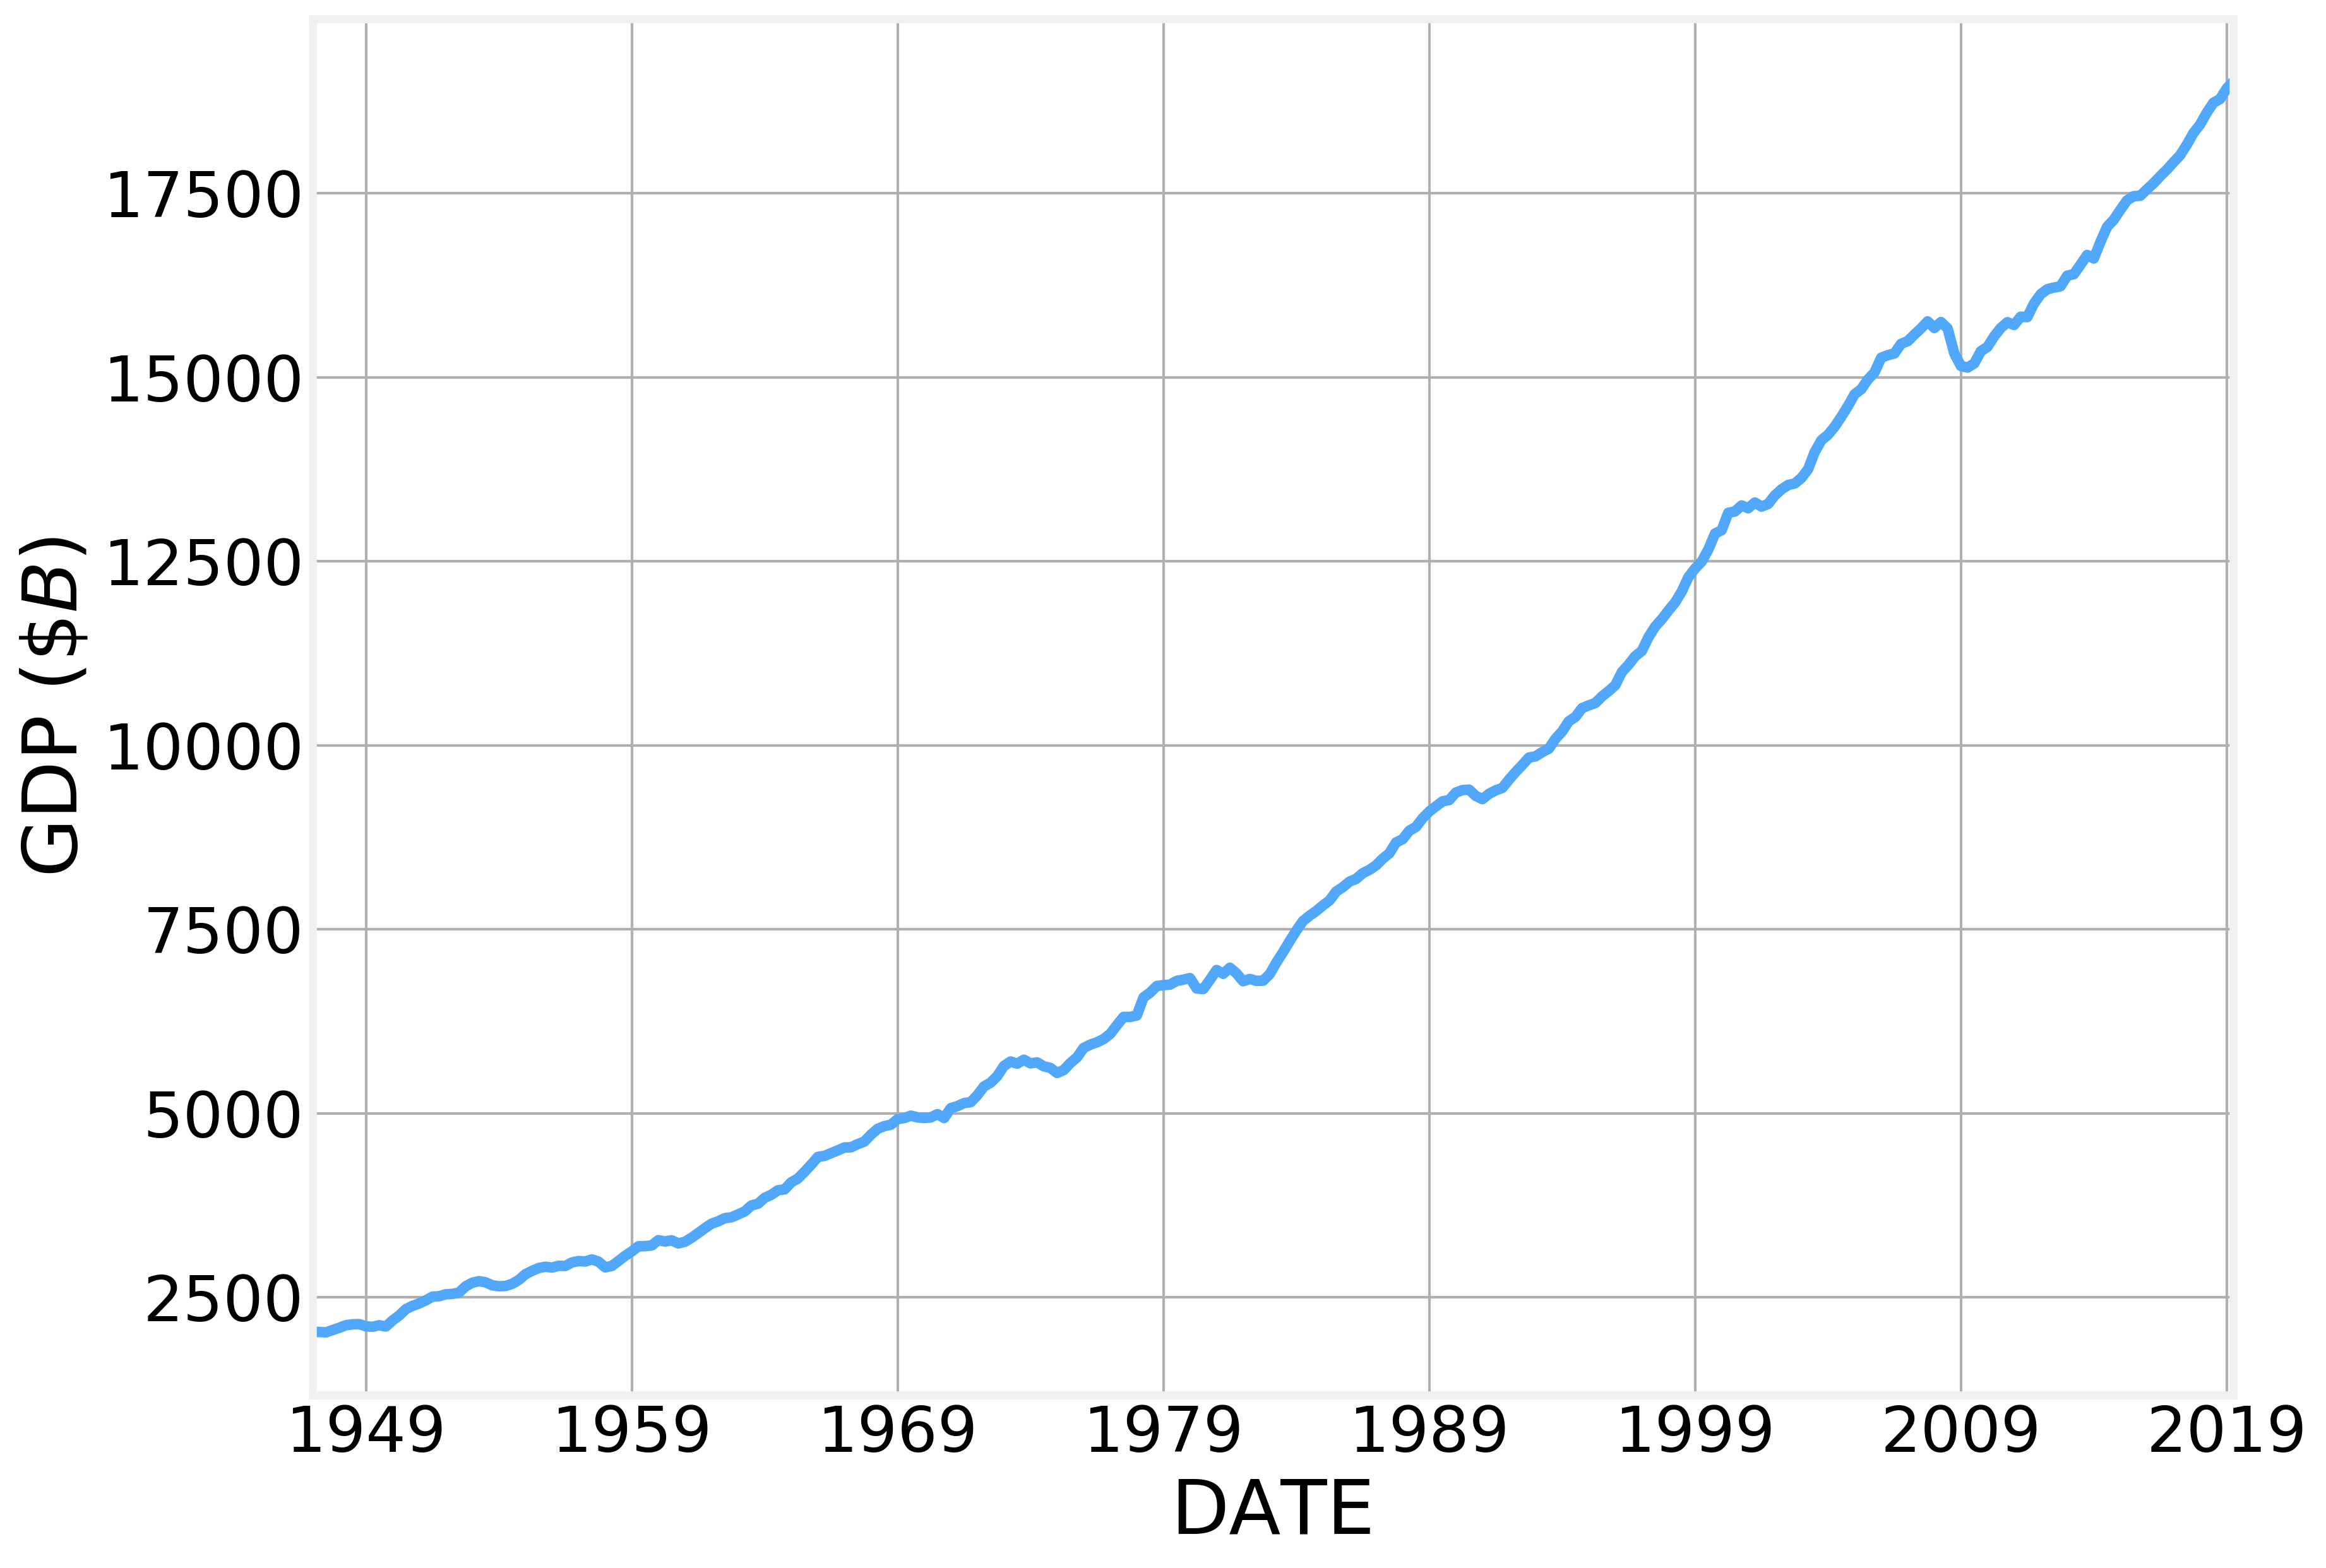

In [17]:
GDP.plot(legend=False)
plt.gca().set_ylabel(r'GDP ($\$B$)')

In [18]:
values = GDP['GDP'].values
detrended = values[1:]-values[:-1]

Since the series has a very strong trend, the auto-correlation function appears to be significant for very long periods

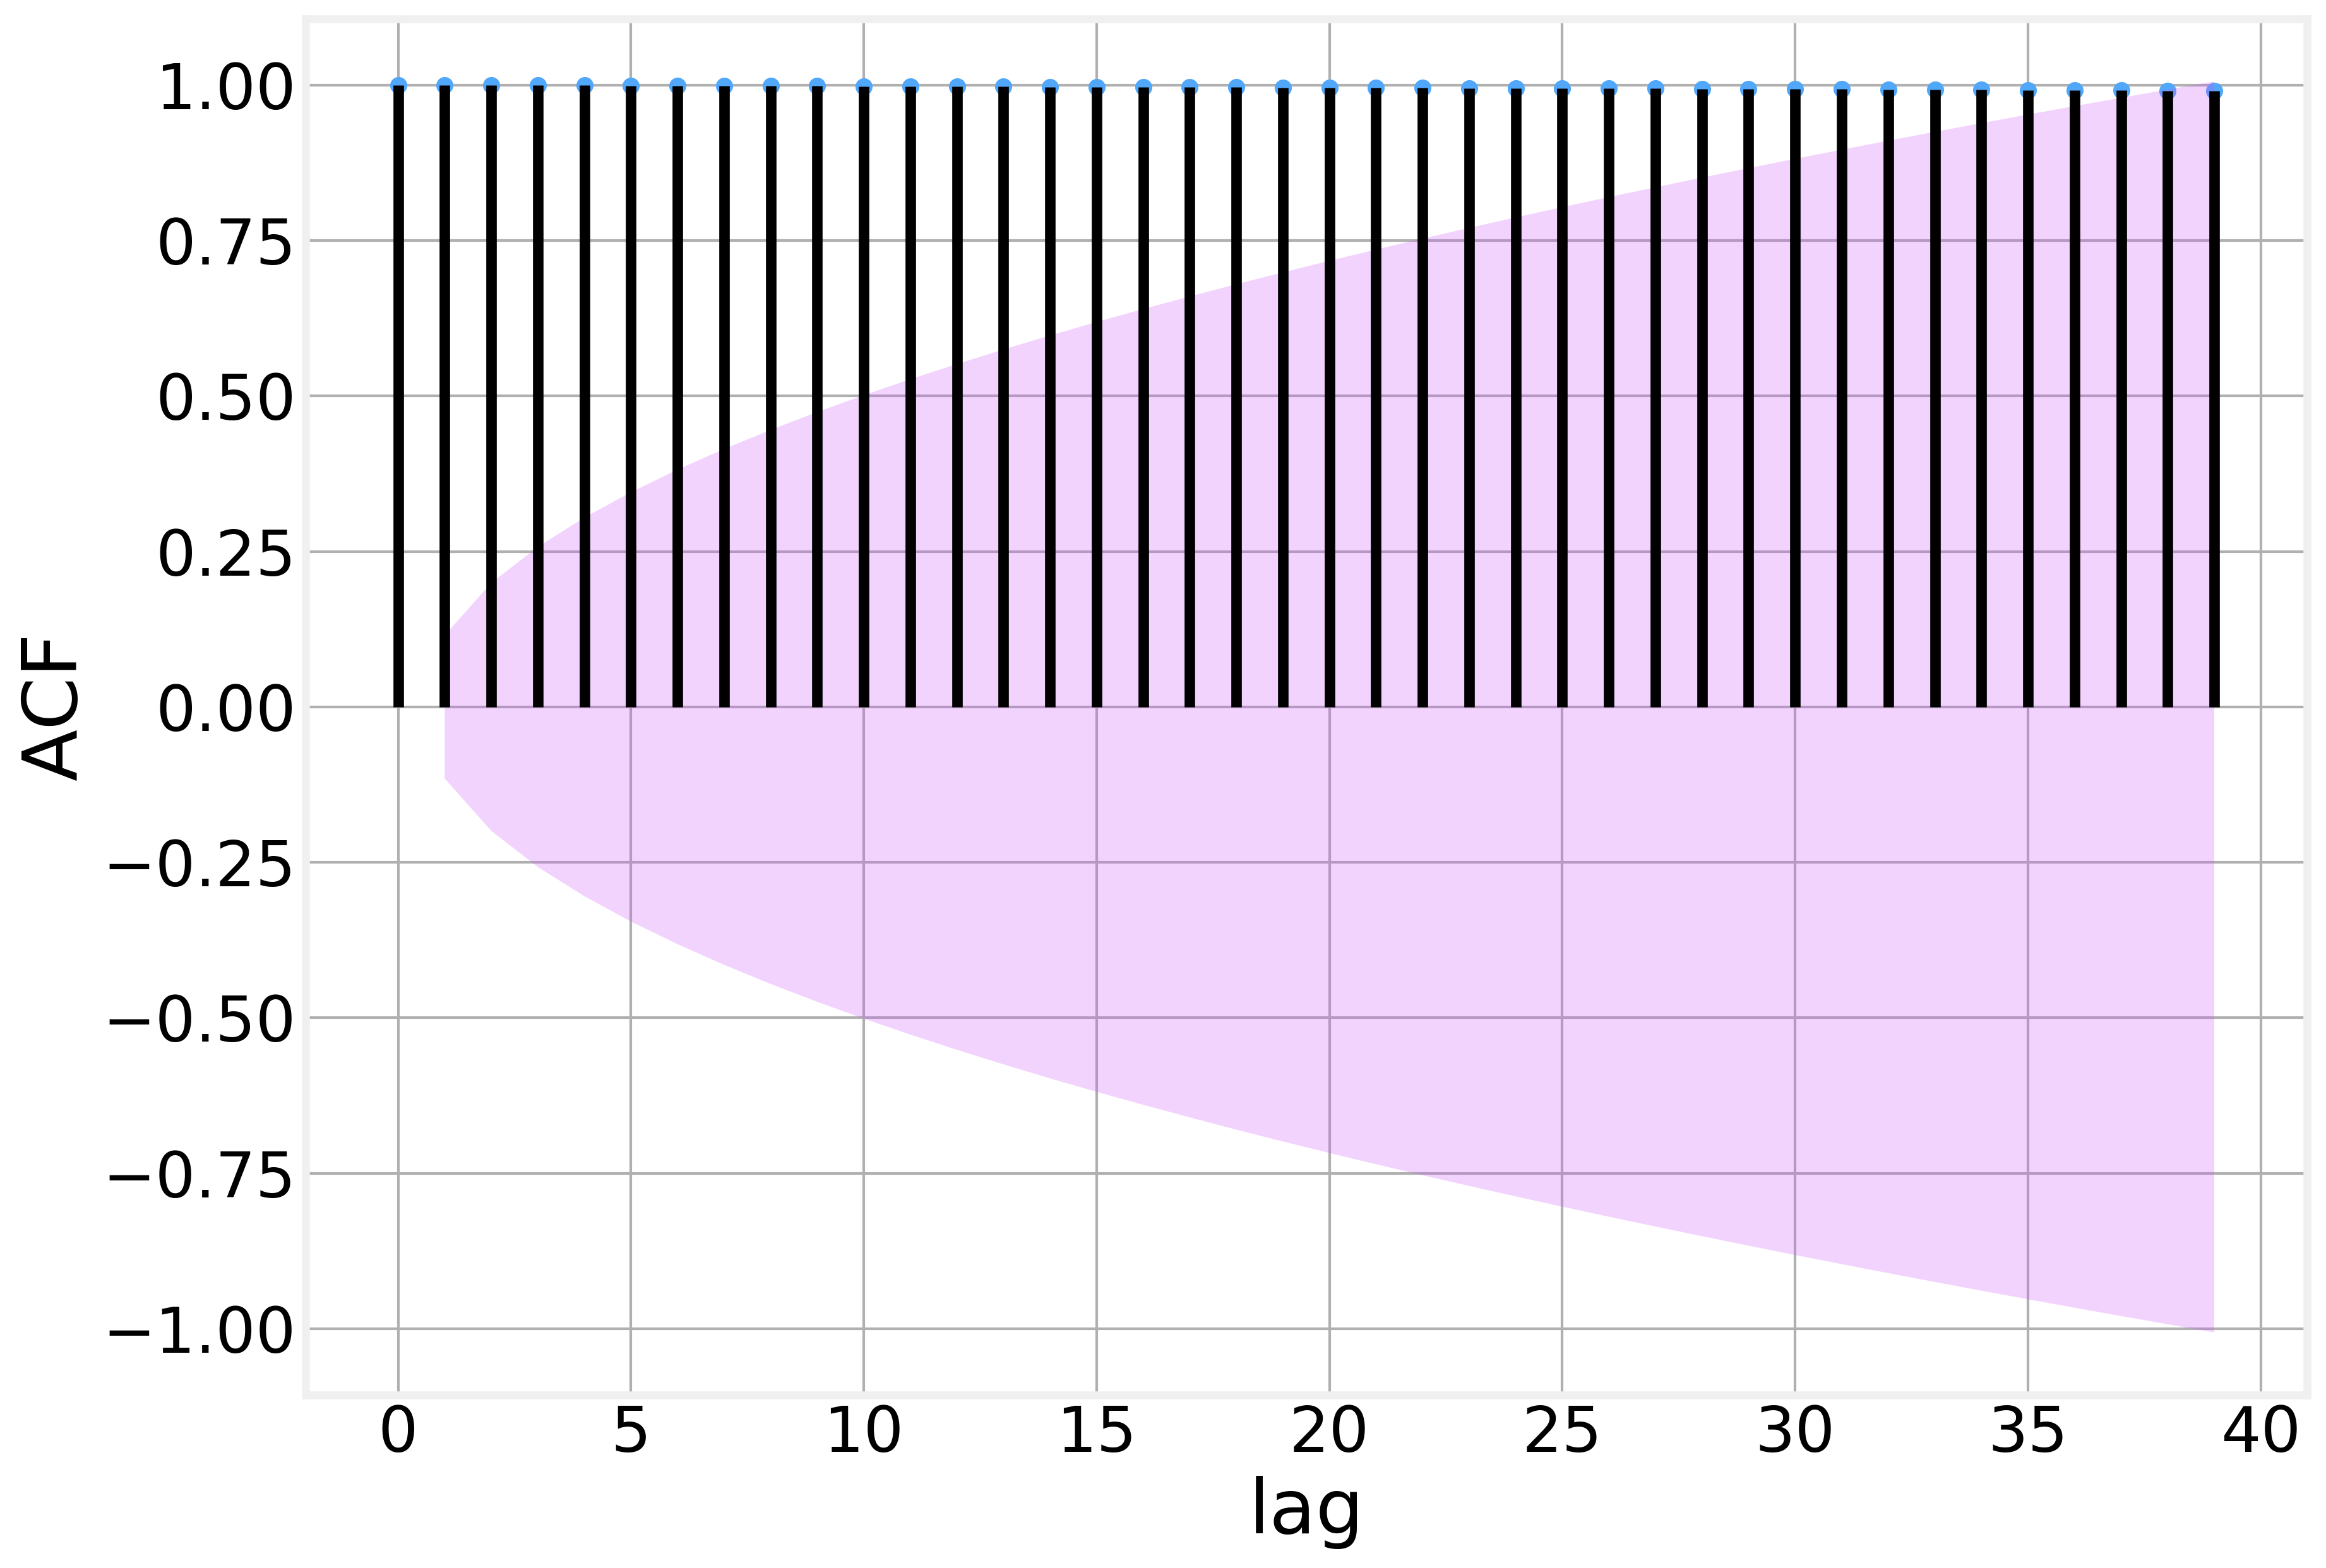

In [19]:
plot_acf(values)

This is one more indication that we must detreend the data

Text(0, 0.5, 'QoQ Change ($\\$B$)')

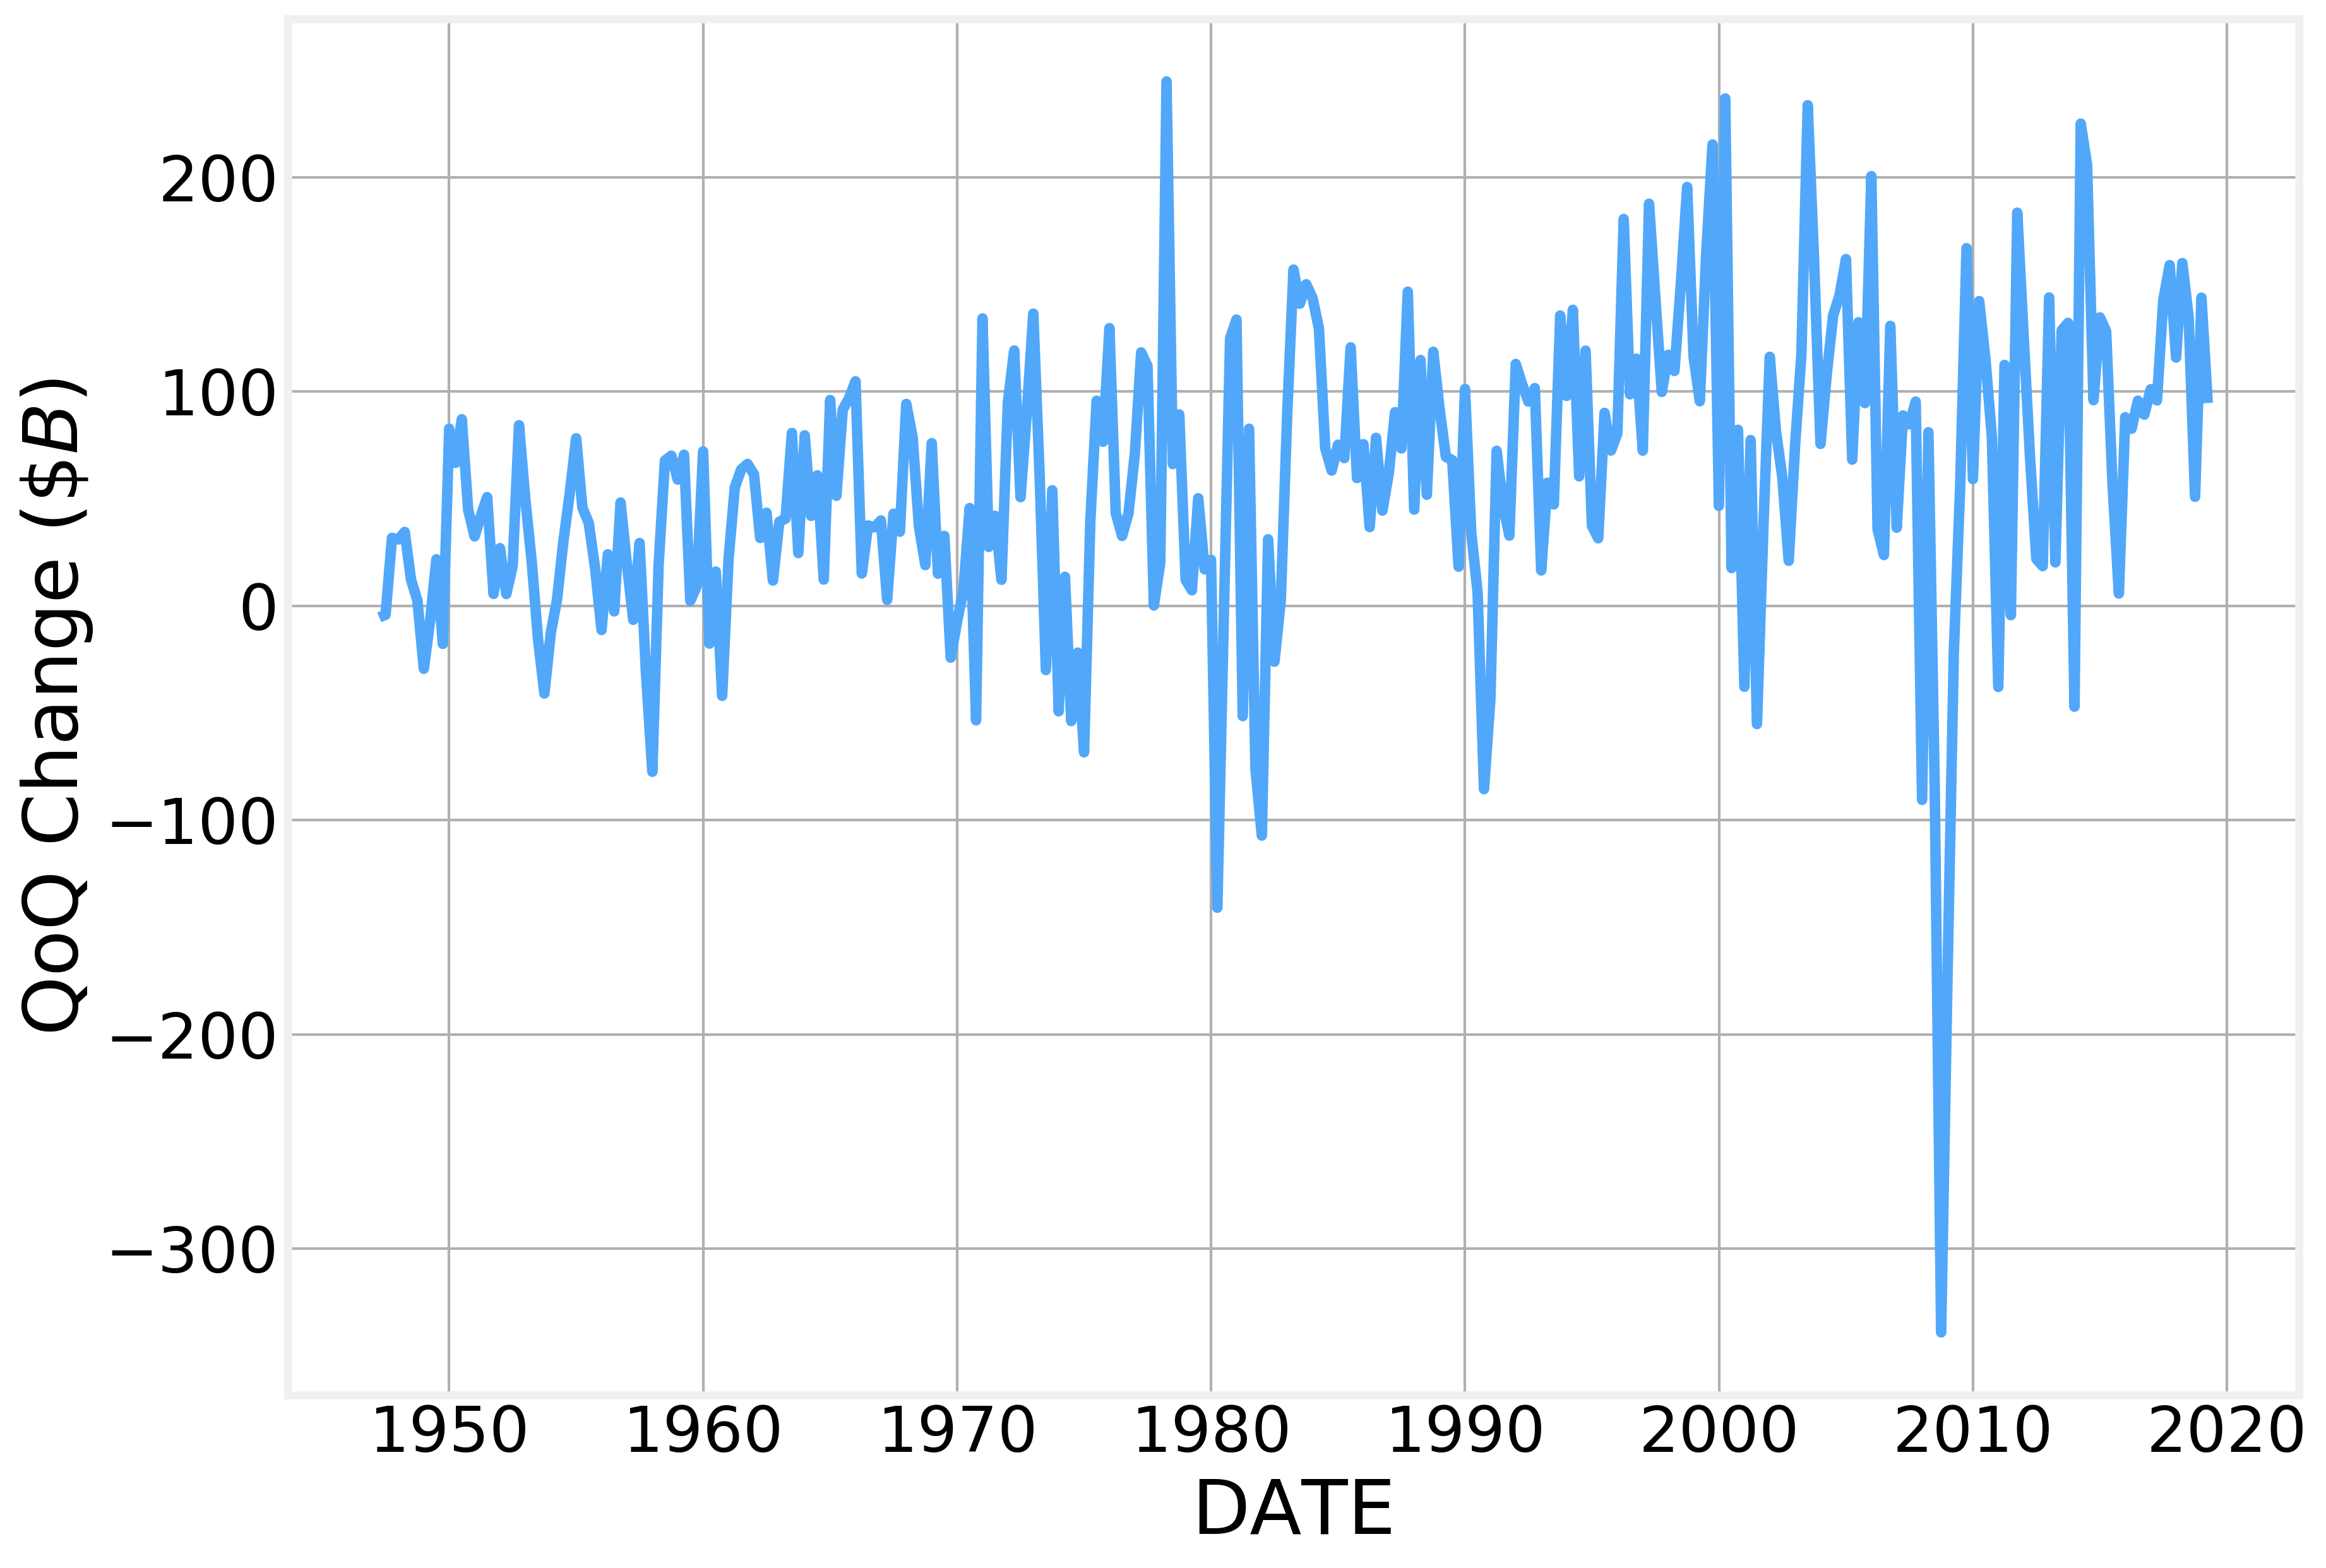

In [20]:
plt.plot(GDP.index[1:], detrended)
plt.xlabel('DATE')
plt.ylabel(r'QoQ Change ($\$B$)')

and much more informative

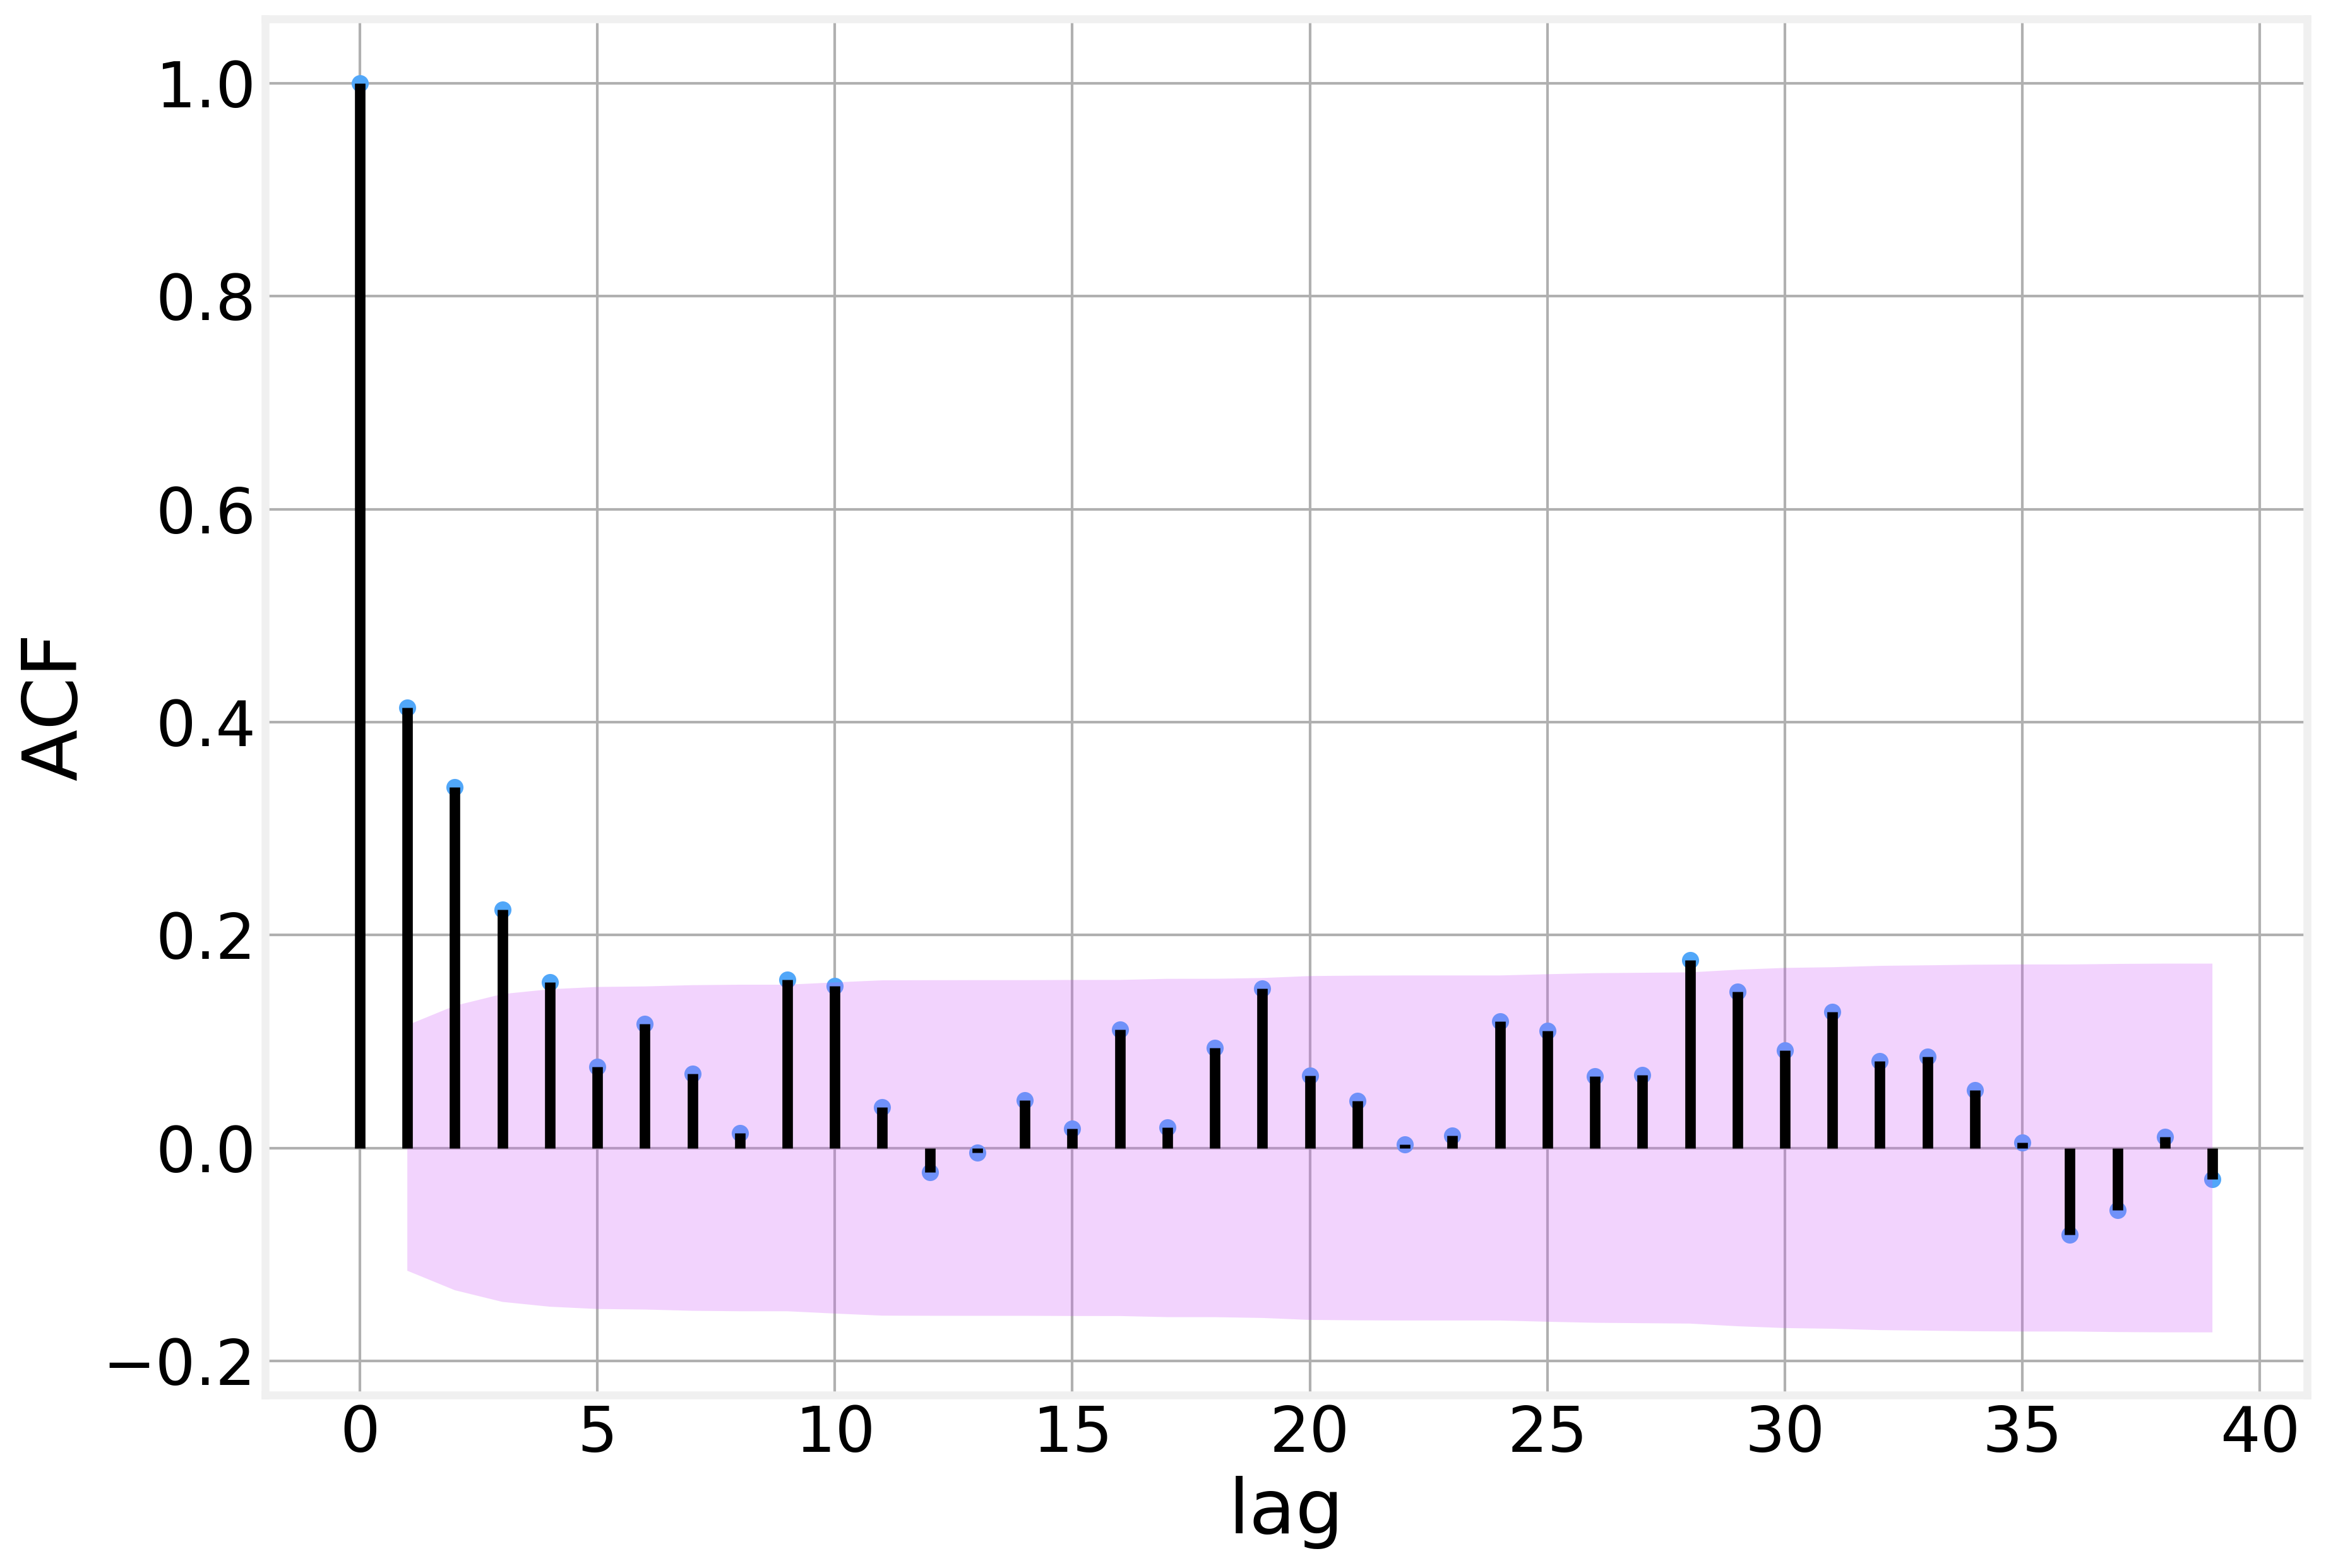

In [21]:
plot_acf(detrended)

# Partial Auto-correlation

The auto-correlation function considers the entire time series for each lag.

In [22]:
def rolling(x, order):
    npoints = x.shape[0]
    running = []
    
    for i in range(npoints-order+1):
        running.append(x[i:i+order])
        
    return np.array(running)

We can also define the partial correlation function that is similar to the ACF but, for each lag, it tries to account for the ammount of correlation that has already been explained by previous lags by using a linear model to predict $x_t$ and $x_{t-l}$

In [23]:
def pacf(x, lag=40):
    y = []
    
    for i in range(3, lag + 2):
        windows = rolling(x, i)

        xt = windows[:, -1] # Current values are at the end
        xt_l = windows[:, 0] # Lagged values are at 0
        inter = windows[:, 1:-1] # Intermediate values are in between 1 and -1
        
        
        lm = LinearRegression(fit_intercept=False).fit(inter, xt)
        xt_fit = lm.predict(inter)

        lm = LinearRegression(fit_intercept=False).fit(inter, xt_l)
        xt_l_fit = lm.predict(inter)

        y.append(pearson(xt - xt_fit, xt_l - xt_l_fit))
    
    # Pad the array with the two missing values
    pacf_1 = acf(x, 2)[1]
    return np.array([1, pacf_1] +  y)

In [24]:
def plot_pacf(x, alpha=0.05, lag=40):
    pacf_val = pacf(x, lag)
    plt.vlines(np.arange(lag + 1), 0, pacf_val)
    plt.scatter(np.arange(lag + 1), pacf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('PACF')
    
    # Determine confidence interval
    ci = acf_ci(pacf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

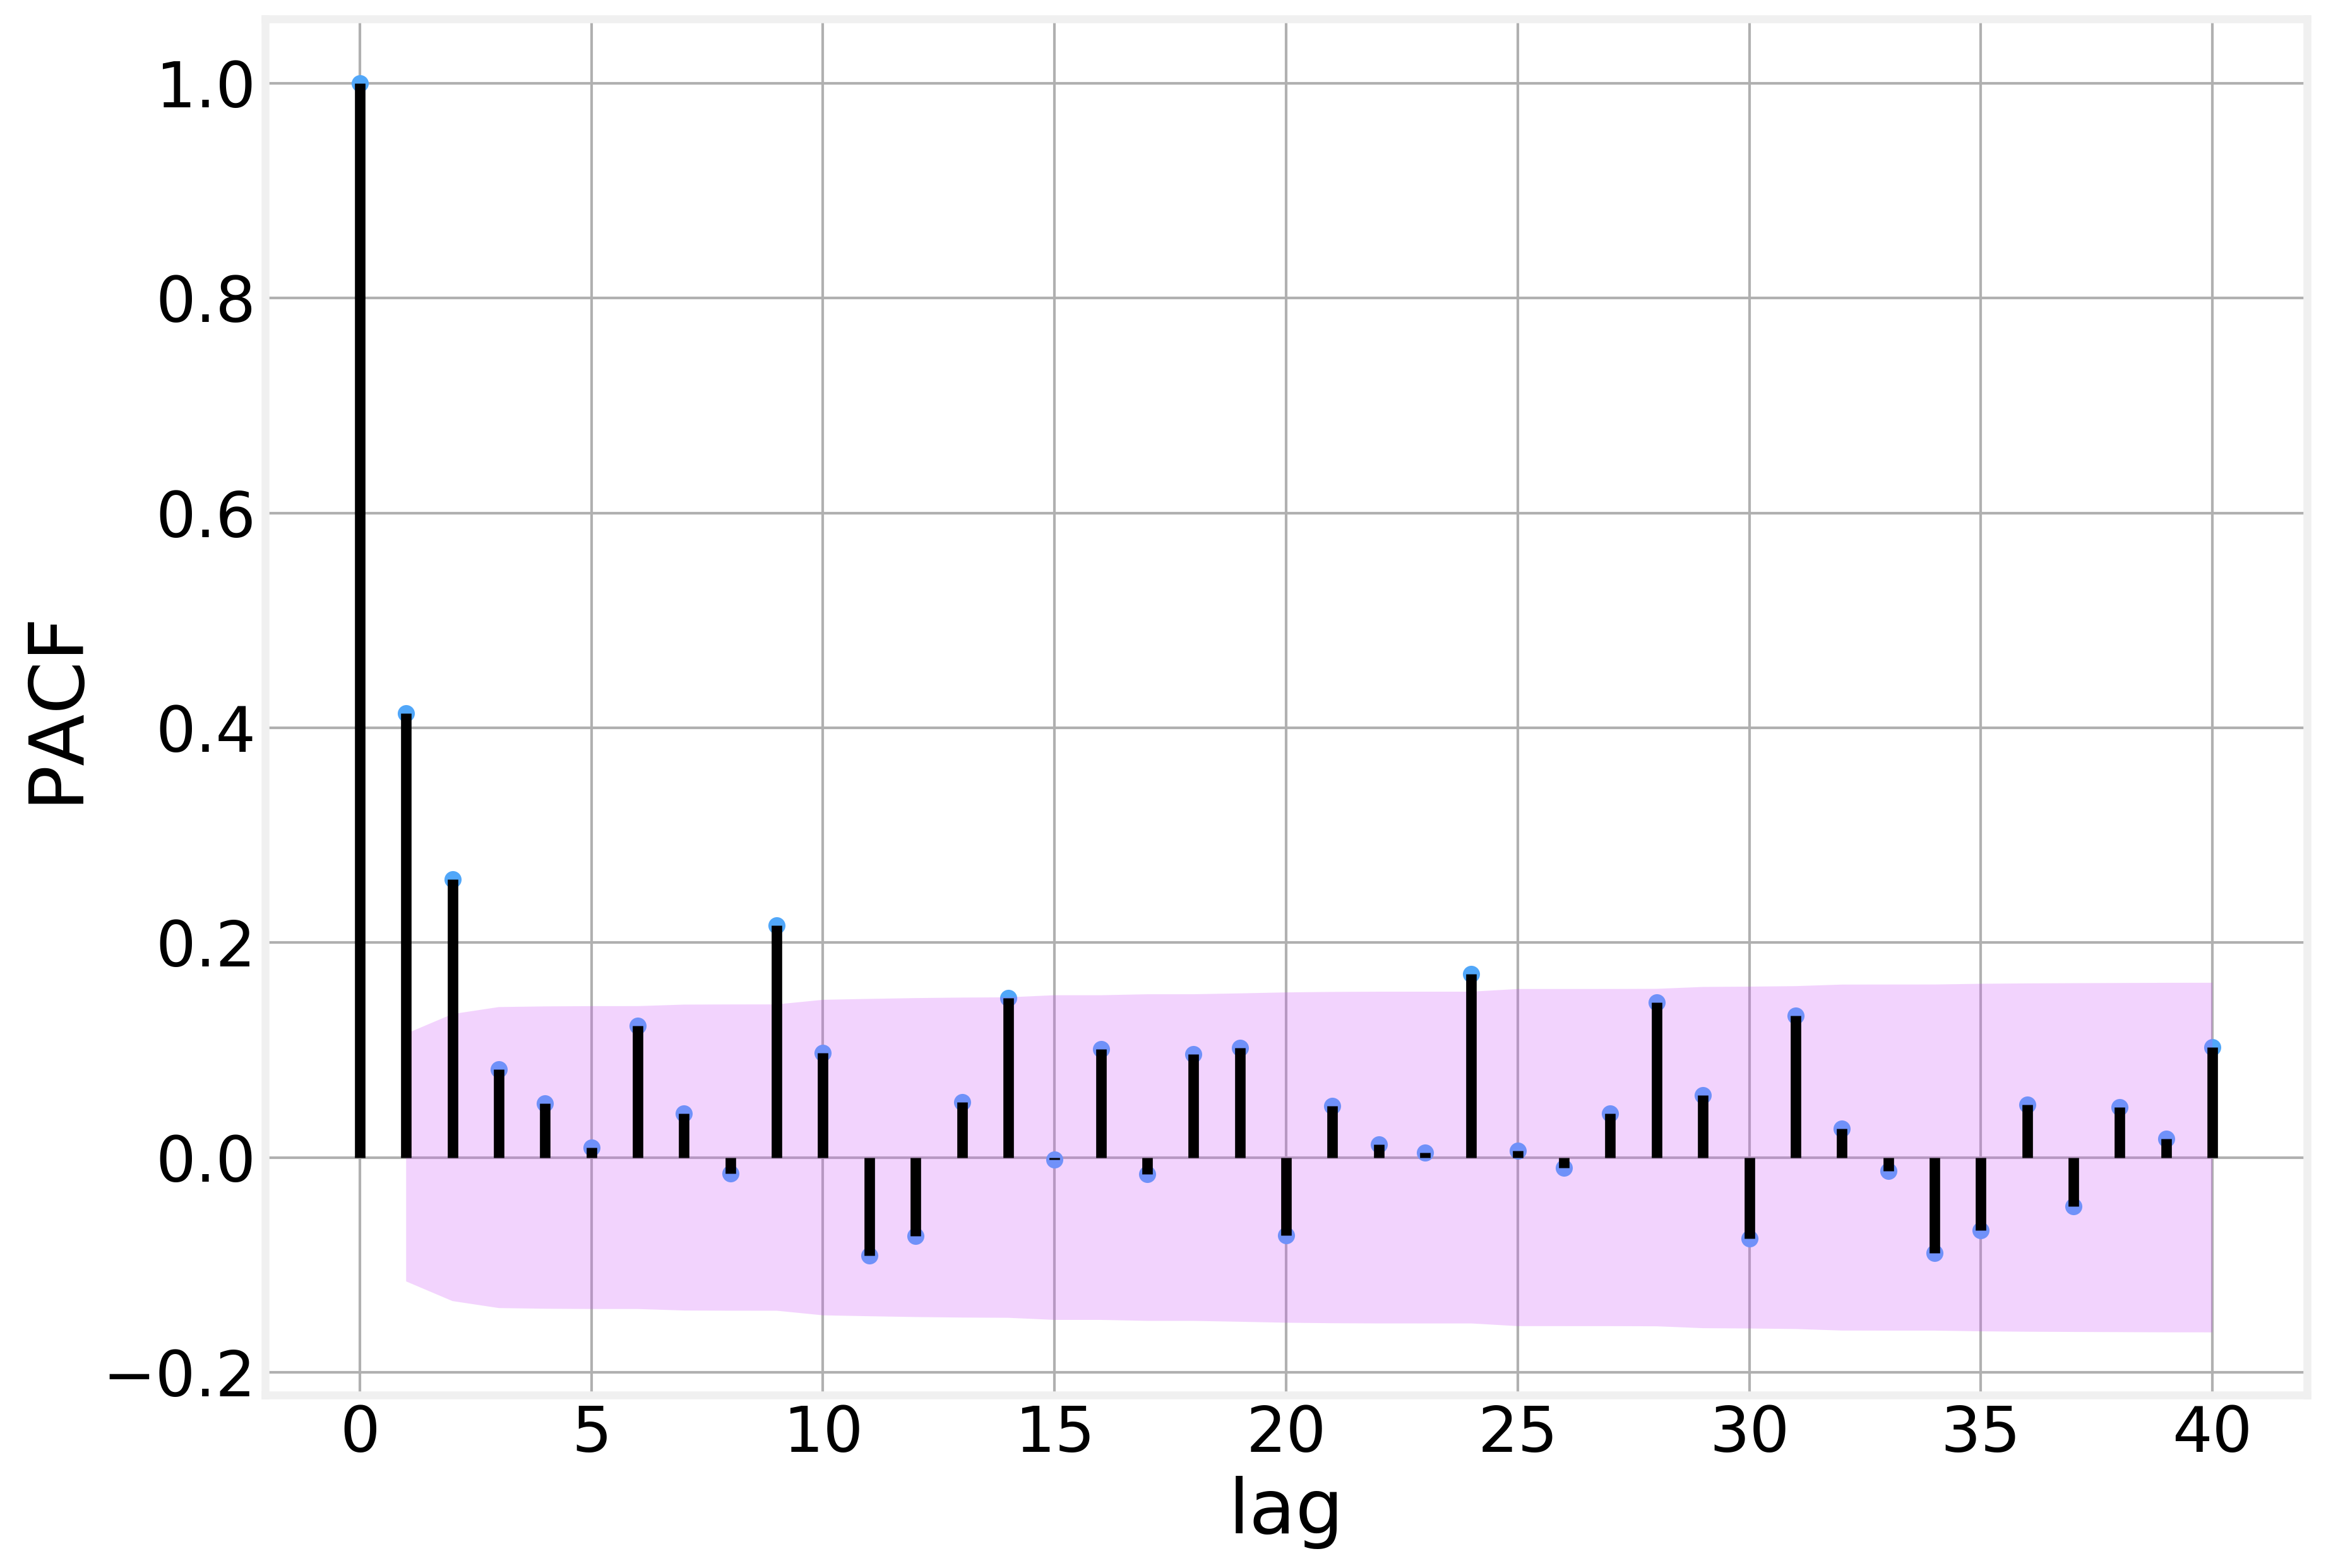

In [25]:
plot_pacf(detrended)

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>